Extension to Pytorch tutorial's [Classifying Names with a Character-Level RNN](http://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html#classifying-names-with-a-character-level-rnn). The main purpose of this script is to demo batch bi-RNN on classification when input dataset has various length. 

In [1]:
import torch
from torch.nn.utils import clip_grad_norm
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torch.utils import data
from torch.autograd import Variable
import torch.nn as nn
import glob, os, string
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt


all_letters = string.ascii_letters + ":.,-\n "
n_letters = len(all_letters)
path_to_files = "./data/names/*.txt"
torch.manual_seed(1)

## Prepare Data

### Process data into a long list [ (language name, country name),...]

In [2]:
def load_data(path_to_files):
    files = glob.glob(path_to_files)
    country_name = [os.path.basename(file).split(".")[0] for file in files]
    name_data = []
    for file, file_name in zip(files, country_name):
        with open(file, 'r') as f:
            names = f.readlines()
        name_data += [(name.strip()+"\n", file_name) for name in names]
    return list(set(name_data)), country_name



### Convert characters into numbers 

In [3]:
def prepare_idx(dat):
    to_ix = {k: v for v, k in enumerate(dat)}
    ix_to = {v: k for k, v in to_ix.items()}
    return to_ix, ix_to

def sort_batch_data(dat):
    # data: [[(name, target), len of name], ...]
    name, target = dat[0]
    length = dat[1]
    sorted_length, sorted_id = length.sort(dim=0, descending=True)
    sorted_name = name[sorted_id]
    sorted_target = target[sorted_id]
    return Variable(torch.t(sorted_name)), Variable(sorted_target).squeeze(), sorted_length

### Prepare dataset via Pytorch's DataLoader
1. Input data format: [ (language name, country name), ... ] 
2. Create two torch long tensor with zeros:
	character_tensor ( n samples, length of longest name)
	target_tensor  (n samples, 1)
3. Convert input data into both tensors. For example, if the longest name has length of 4, a name with length of 2 will be padded 2 zeros at the end. 

In [4]:
class NameDataset(data.Dataset):
    def __init__(self, data, char_to_idx, target_to_idx):
        super(NameDataset, self).__init__()
        self.data = data
        self.names = [x[0] for x in data]
        self.targets = [x[1] for x in data]
        self.n_sampel = len(self.data)
        self.length = [len(x[0]) for x in self.data]

        self.char_to_idx = char_to_idx
        self.target_to_idx = target_to_idx
        self.char_tensor = torch.zeros((self.n_sampel, max(self.length))).long()
        self.target_tensor = torch.zeros((self.n_sampel, 1)).long()
        self.process_data()

    def process_data(self):
        for i in range(self.n_sampel):
            name, target = self.data[i]
            self.char_tensor[i, :self.length[i]] = self.convert_to_tensor(name, self.char_to_idx)
            self.target_tensor[i, :] = self.convert_to_tensor([target], self.target_to_idx)

    @staticmethod
    def convert_to_tensor(char, idx):
        return torch.LongTensor([idx[i] for i in char])

    def __getitem__(self, index):
        return [(self.char_tensor[index], self.target_tensor[index]), self.length[index]]

    def __len__(self):
        return len(self.data)

## The RNN Model:
1. Character level embedding 
2. LSTM or GRU: bi-directional with dropout rate of 0.7
3. Linear combination 
4. Sum over all character values
5. Softmax 
6. Gradient clipping
7. Adam optimization with L2 regularization  of 0.0005. Initial learning rate is 1e-3
8. Learning rate declining  scheme

In [5]:
class RecurrentNet(nn.Module):
    def __init__(self, vocab_size, vocab_embed, hidden_dim, target_size, type):
        super(RecurrentNet, self).__init__()
        self.vocab_embed = vocab_embed
        self.hidden_dim = hidden_dim

        self.embed = nn.Embedding(vocab_size, vocab_embed)
        if type =='LSTM':
            self.rnn = nn.LSTM(vocab_embed, hidden_dim//2, num_layers=1, bias=True, bidirectional=True, dropout=0.7)
        elif type == 'GRU':
            self.rnn = nn.GRU(vocab_embed, hidden_dim//2, num_layers=1, bias=True, bidirectional=True, dropout=0.7)
        else:
            raise SyntaxError("Type Error. Either LSTM or GRU")
        self.type = type
        self.char_2_tag = nn.Linear(hidden_dim, target_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def init_hidden(self, batch_size):
        if self.type == "LSTM":
            hidden_layers = (Variable(torch.zeros((2, batch_size, self.hidden_dim // 2))),
                             Variable(torch.zeros((2, batch_size, self.hidden_dim // 2))))
        elif self.type == 'GRU':
            hidden_layers = Variable(torch.zeros((2, batch_size, self.hidden_dim // 2)))
        return hidden_layers

    def forward(self, name_tensor, sorted_length):
        embed_name = self.embed(name_tensor)
        packed_name = pack_padded_sequence(embed_name, sorted_length.tolist())
        char_gru, char_hidden = self.rnn(packed_name, self.hidden)
        pad_char, _ = pad_packed_sequence(char_gru)
        target_space = self.char_2_tag(pad_char)
        target_space = target_space.sum(dim=0)
        target_score = self.softmax(target_space)
        return target_score


## Prepare train/dev/test data
The input data has various counts for each country, so I split it by weights of each country. 

Train: 80%  used to build the model

Dev : 10%  used to configure model parameters

Test : 10% test

In [6]:
def split_data(data, test_size=0.2, train_size=0.8, random_state=1):
    splitter = StratifiedShuffleSplit(test_size=test_size,
                                      train_size=train_size,
                                      random_state=random_state)
    y_true = [x[1] for x in data]
    for train_index, test_index in splitter.split(data, y_true):
        train = [data[i] for i in train_index]
        test = [data[i] for i in test_index]
    return train, test

In [7]:
name_data, countries = load_data(path_to_files)
print(name_data[:5])
print(countries[:5])


[('Finnimore\n', 'English'), ('Hinds\n', 'English'), ('Tai\n', 'Chinese'), ('Exton\n', 'English'), ('Miyamae\n', 'Japanese')]
['Arabic', 'Chinese', 'English', 'Japanese', 'Korean']


In [8]:
train, test_ = split_data(name_data, test_size=0.2, train_size=0.8, random_state=1)
print("Length of training set {}".format(len(train)))

Length of training set 4084


In [9]:
dev, test = split_data(test_, test_size=0.5, train_size=0.5, random_state=2)
print("Length of dev set {};\nlength of test set {}.".format(len(dev),len(test)))

Length of dev set 511;
length of test set 511.


In [10]:
char_to_ix, ix_to_char = prepare_idx(all_letters)
target_to_ix, ix_to_target = prepare_idx(countries)

batch_size = 64

In [11]:
train_set = NameDataset(train, char_to_ix, target_to_ix)
train_data = DataLoader(train_set, batch_size, shuffle=True)

dev_set = NameDataset(dev, char_to_ix, target_to_ix)
dev_data = DataLoader(dev_set, batch_size, shuffle=True)

test_set = NameDataset(test, char_to_ix, target_to_ix)
test_data = DataLoader(test_set, len(test), shuffle=True)

To speed up backprop, I clip gradientss that are larger than 10 and add a learning rate declinding scheme.

In [12]:
vocab_size = len(char_to_ix)
target_size = len(target_to_ix)
vocab_embed = 80
hidden_dim = 60
iterations = 10

model = RecurrentNet(vocab_size, vocab_embed, hidden_dim, target_size, "LSTM")
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0005)
optim_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, verbose=True, patience=1)
loss_cache = []


In [13]:
for i in range(iterations):
    total_loss = []
    for batch_data in train_data:
        name, target, length = sort_batch_data(batch_data)
        batch_size = len(length)
        model.zero_grad()
        model.hidden = model.init_hidden(batch_size)
        target_score = model(name, length)
        loss = loss_fn(target_score, target)
        loss.backward()
        clip_grad_norm(model.parameters(), max_norm=10)
        optimizer.step()
        total_loss.append(loss.data[0] * batch_size)
    loss_avg = sum(total_loss) / len(total_loss)
    optim_scheduler.step(loss_avg)
    print("Epoch {} : {:.5f}".format(i+1, loss_avg))
    loss_cache.append(loss_avg)

Epoch 1 : 38.08849
Epoch 2 : 22.18404
Epoch 3 : 17.12583
Epoch 4 : 14.36953
Epoch 5 : 12.81506
Epoch 6 : 11.73068
Epoch 7 : 10.74078
Epoch 8 : 10.23288
Epoch 9 : 9.61407
Epoch 10 : 9.01092


### Learning Curve:

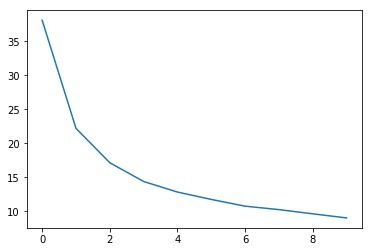

In [14]:
plt.plot(loss_cache)


### Evaluation
Main metric is average accuracy. Additional scores such as F1 and confusion matrix are used to analysis error. 


In [15]:
def evaluation(data):
    # post-process data from data loader
    target_pred = []
    target_true = []
    for batch_data in data:
        name, target, length = sort_batch_data(batch_data)
        batch_size = len(length)
        model.hidden = model.init_hidden(batch_size)
        target_score = model(name, length)
        score, category = torch.max(target_score, dim=1)
        target_pred += category.data.tolist()
        target_true += target.data.tolist()
    return target_pred, target_true

#### Training Data Result

In [16]:
target_pred, target_true = evaluation(train_data)
accuracy = accuracy_score(target_true, target_pred)
print("Accuracy rate is {:.4f}".format(accuracy))

Accuracy rate is 0.9591


In [17]:
report = classification_report(target_true, target_pred, target_names=list(target_to_ix))
print(report)

error_matrix = confusion_matrix(target_true, target_pred)
print("M_{i,j} where i is true group and j is predicted group\n")
print(list(target_to_ix))
print(error_matrix)

y_true = [ix_to_target[i] for i in target_true]
y_pred = [ix_to_target[i] for i in target_pred]

             precision    recall  f1-score   support

     Arabic       0.76      0.43      0.55        86
    Chinese       0.77      0.91      0.84       197
    English       0.98      0.99      0.98      2934
   Japanese       0.98      0.96      0.97       792
     Korean       0.66      0.44      0.53        75

avg / total       0.96      0.96      0.96      4084

M_{i,j} where i is true group and j is predicted group

['Arabic', 'Chinese', 'English', 'Japanese', 'Korean']
[[  37    3   36    9    1]
 [   0  180    4    3   10]
 [   8   12 2905    5    4]
 [   3    7   18  762    2]
 [   1   32    8    1   33]]


#### Dev Data Result

In [18]:
target_pred, target_true = evaluation(dev_data)
accuracy = accuracy_score(target_true, target_pred)
print("Accuracy rate is {:.4f}".format(accuracy))

Accuracy rate is 0.9315


In [19]:
report = classification_report(target_true, target_pred, target_names=list(target_to_ix))
print(report)

error_matrix = confusion_matrix(target_true, target_pred)
print("M_{i,j} where i is true group and j is predicted group\n")
print(list(target_to_ix))
print(error_matrix)

y_true = [ix_to_target[i] for i in target_true]
y_pred = [ix_to_target[i] for i in target_pred]

             precision    recall  f1-score   support

     Arabic       0.50      0.27      0.35        11
    Chinese       0.59      0.83      0.69        24
    English       0.98      0.98      0.98       367
   Japanese       0.92      0.93      0.92        99
     Korean       0.33      0.20      0.25        10

avg / total       0.93      0.93      0.93       511

M_{i,j} where i is true group and j is predicted group

['Arabic', 'Chinese', 'English', 'Japanese', 'Korean']
[[  3   0   4   4   0]
 [  0  20   1   1   2]
 [  1   4 359   1   2]
 [  2   4   1  92   0]
 [  0   6   0   2   2]]


#### Test Data Result

In [20]:
target_pred, target_true = evaluation(test_data)
accuracy = accuracy_score(target_true, target_pred)
print("Accuracy rate is {:.4f}".format(accuracy))

Accuracy rate is 0.9335


In [21]:
report = classification_report(target_true, target_pred, target_names=list(target_to_ix))
print(report)

error_matrix = confusion_matrix(target_true, target_pred)
print("M_{i,j} where i is true group and j is predicted group\n")
print(list(target_to_ix))
print(error_matrix)

y_true = [ix_to_target[i] for i in target_true]
y_pred = [ix_to_target[i] for i in target_pred]

             precision    recall  f1-score   support

     Arabic       0.50      0.18      0.27        11
    Chinese       0.71      0.80      0.75        25
    English       0.96      0.98      0.97       367
   Japanese       0.93      0.96      0.95        99
     Korean       0.33      0.22      0.27         9

avg / total       0.93      0.93      0.93       511

M_{i,j} where i is true group and j is predicted group

['Arabic', 'Chinese', 'English', 'Japanese', 'Korean']
[[  2   0   7   2   0]
 [  0  20   2   0   3]
 [  1   2 358   5   1]
 [  1   0   3  95   0]
 [  0   6   1   0   2]]
